In [1]:
# -*- coding: utf-8 -*-
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import os
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

/Users/xuxiang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
## keras
from keras.models import Sequential
# serialization
import cPickle

Using Theano backend.


In [3]:
unique_tags_csv = '/Users/xuxiang/ml/terrain-context/osm_tags/unique_tags.csv'
# label-lookup
labels_lookup = []
count = 0
with open(unique_tags_csv) as f:
    for line in f:
        (tag, tag_cn, label) = line.strip().split(',')
        if count != int(label):
            print 'invalid label loopup!'
        labels_lookup.append(tag_cn)
        print count, tag_cn
        count = count + 1

0 商业用地
1 水渠
2 草地
3 工业用地
4 湖泊
5 球场
6 采矿场
7 水库
8 居住区
9 河流
10 灌木
11 林地
12 沙滩
13 建筑
14 烟囱
15 悬崖
16 海岸
17 冰川区
18 温室
19 停车场
20 山峰
21 码头
22 绿茵场
23 存储罐
24 收费站
25 塔
26 跑道
27 水域
28 湿地
29 月台
30 铁路
31 道路


In [4]:
def show_topn_error(y_true, y_pred, n):
    correct = 0
    for row in range(0, len(y_pred)):
        a = list(pred[row])
        b = sorted(range(len(a)), key=lambda i: a[i])[-n:]

        if y_true[row] in b:
            correct += 1

    top_5_error = 1 - float(correct) / float(len(y_true))
    print 'top-%d error: %f' % (n, top_5_error)

In [5]:
# Open test file
x_test_file = '/Users/xuxiang/ml/terrain-context/features/x_test_bvlc_fc7.pkl'
y_test_file = '/Users/xuxiang/ml/terrain-context/features/y_test_bvlc_fc7.pkl'
with open(x_test_file, 'rb') as f:
    X_test = cPickle.load(f)
    
with open(y_test_file, 'rb') as f:
    y_test = cPickle.load(f)

In [6]:
X_test.shape

(17501, 4096)

In [7]:
from keras.utils import np_utils

X_test = X_test.astype('float32')
Y_test = np_utils.to_categorical(y_test, len(labels_lookup))

In [8]:
Y_test.shape

(17501, 32)

In [9]:
# load model
from keras.models import model_from_json

model_archiecture = '/Users/xuxiang/ml/terrain-context/models/model_architecture_bvlc_fc7.json'
model_weights = '/Users/xuxiang/ml/terrain-context/models/model_weights_bvlc_fc7.h5'

model = model_from_json(open(model_archiecture).read())
model.load_weights(model_weights)

# Finally, before it can be used, the model shall be compiled.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
score, acc = model.evaluate(X_test, Y_test, batch_size=16)
print '\ntop-1 error: %f' % (acc)

17472/17501 [============================>.] - ETA: 0s
top-1 error: 0.471573


In [11]:
pred = model.predict(X_test)

In [12]:
show_topn_error(y_test, pred, 5)

top-5 error: 0.204903


In [13]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '/Users/xuxiang/ml/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
import leveldb
from caffe.proto import caffe_pb2

db = leveldb.LevelDB('/Users/xuxiang/ml/google_image/process/features')

count = 1
keys = list()
for key, value in db.RangeIter():
    datum = caffe_pb2.Datum.FromString(db.Get(key))
    data = caffe.io.datum_to_array(datum)
    feat = np.transpose(data[:, 0])[0]
    keys.append(key)
    if count == 1:
        features = feat
        count += 1
    else:
        features = np.row_stack((features, feat))
features.shape

(2000, 4096)

In [14]:
features = features.astype('float32')
pred = model.predict(features)

In [15]:
count = 0
filenames = list()
with open('/Users/xuxiang/ml/google_image/process/image_list.txt') as f:
    for line in f.readlines():
        filenames.append(line.split()[0])
filenames[:10]

['/Users/xuxiang/ml/google_image/tiles/L18/18_215696_99236.png',
 '/Users/xuxiang/ml/google_image/tiles/L18/18_215696_99237.png',
 '/Users/xuxiang/ml/google_image/tiles/L18/18_215696_99238.png',
 '/Users/xuxiang/ml/google_image/tiles/L18/18_215696_99239.png',
 '/Users/xuxiang/ml/google_image/tiles/L18/18_215696_99240.png',
 '/Users/xuxiang/ml/google_image/tiles/L18/18_215696_99241.png',
 '/Users/xuxiang/ml/google_image/tiles/L18/18_215696_99242.png',
 '/Users/xuxiang/ml/google_image/tiles/L18/18_215696_99243.png',
 '/Users/xuxiang/ml/google_image/tiles/L18/18_215696_99244.png',
 '/Users/xuxiang/ml/google_image/tiles/L18/18_215696_99245.png']

In [16]:
from IPython.display import Image
from IPython.display import display
def showimg(imgpath):
    return Image(imgpath)

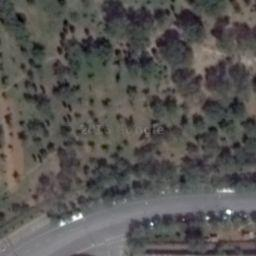

In [39]:
# 13, 100, 75, 78, 125
# 0 植被
# 15 停车场
# 42 湖泊
# 82 水，农作物
# 133 高速公路
# 362 苗圃
# 378 小区
# 396 厂房

# 274 高楼
# 499
# 501 河流
# 1652，1479 球场
# 707 温室
# 1122 林地
# 1234 临街建筑
idx = 1122
test_filename = filenames[idx]
showimg(test_filename)

In [40]:
a = list(pred[idx])
b = sorted(range(len(a)), key=lambda i: a[i])[-5:]
for i in range(1, 6):
    ii = b[5 - i]
    if a[ii] > 0.1:
        print labels_lookup[ii], a[ii]

林地 0.409303545952
草地 0.298866897821
